In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ln -s /content/drive/My\ Drive/People_Detection/dadosImagem /content/Aula

In [0]:
!ls Aula/Teste

negativos  positivos


In [0]:
!pip uninstall opencv-python -y

Uninstalling opencv-python-3.4.7.28:
  Successfully uninstalled opencv-python-3.4.7.28


In [0]:
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

     |████████████████████████████████| 30.6MB 20.2MB/s 
     |████████████████████████████████| 20.0MB 177kB/s 
ERROR: tensor2tensor 1.14.1 requires opencv-python, which is not installed.
ERROR: stable-baselines 2.2.1 requires opencv-python, which is not installed.
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.17.3
    Uninstalling numpy-1.17.3:
      Successfully uninstalled numpy-1.17.3
  Found existing installation: opencv-contrib-python 3.4.3.18
    Uninstalling opencv-contrib-python-3.4.3.18:
      Successfully uninstalled opencv-contrib-p

In [0]:
import cv2

class Descritor:

    @staticmethod
    def get_SIFT_descritores(img_caminho):
        
        LARGURA = 360
        ALTURA = 360
        
        # Ler a imgem
        img_teste = cv2.imread(img_caminho, 0)
        
        #Redimensionar
        img_redimensionada = cv2.resize(img_teste, (LARGURA, ALTURA), interpolation=cv2.INTER_CUBIC)
        
        # Remover ruídos
        img_equalizada = cv2.equalizeHist(img_redimensionada)
        img_suavizada = cv2.GaussianBlur(img_equalizada, (9,9), 1)
        
        #Detectar pontos chaves
        sift = cv2.xfeatures2d.SIFT_create(nfeatures=512)
        pontos_chave = sift.detect(img_suavizada, None)
        
        pontos_chave, descritores = sift.compute(img_suavizada, pontos_chave)
        
        return descritores

    @staticmethod
    def salvar_descritor(descritor, caminho, nome_arquivo):
        descritor = descritor.reshape((1,descritor.size))
        arquivo = open(os.path.join(caminho, nome_arquivo), 'a')
        np.savetxt(arquivo, descritor, delimiter=',', fmt='%i')
        arquivo.close()
    
    @staticmethod
    def carregar_descritores(caminho, nome_arquivo='orb_descritor.csv'):
        descritores = np.loadtxt(os.path.join(caminho, nome_arquivo), delimiter=',')
        print('formato do array de descritores: ', descritores.shape)
        return descritores

In [0]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import os
import numpy as np

In [0]:
QUANTIDADE_PALAVRAS_VIRTUAIS = 128

class PacoteDePalavras:
    
    def gerar_dicionario(self, lista_descritores):
        kmeans = KMeans(n_clusters = QUANTIDADE_PALAVRAS_VIRTUAIS)
        kmenas = kmeans.fit(lista_descritores)
        self.dicionario = kmeans.cluster_centers_
        
    def histograma_de_frequencia(self, descritor):

        try:
            algoritmo_knn = NearestNeighbors(n_neighbors = 1)
            algoritmo_knn.fit(self.dicionario)
            mais_proximos = algoritmo_knn.kneighbors(descritor, return_distance = False).flatten()

            histograma_caracteristica = np.histogram(mais_proximos, bins=np.arange(self.dicionario.shape[0]+1))[0]
        
            return histograma_caracteristica
        except AttributeError:
            print("O atributo dicionario nao foi definido")
            
    def salvar_dicionario(self, caminho='', nome_dicionario = 'dicionario.csv'):
        try:
            np.savetxt(os.path.join(caminho, nome_dicionario), self.dicionario, delimiter=',', fmt='%f')
            print("Dicionario salvo")
            
        except AttributeError:
            print("Dicionario Vazio")

    def carregar_dicionario(self, caminho='', nome_dicionario = 'dicionario.csv'):

        self.dicionario = np.loadtxt(os.path.join(caminho,nome_dicionario), delimiter=',')
    

In [0]:
def arquivo_diretorio(caminho):

    for raiz,diretorios,arquivos in os.walk(caminho):
        for arquivo in arquivos:
            if arquivo.endswith('.png'):
                yield arquivo

In [0]:
DICIONARIO_NOME = 'dicionario.csv'
dados_treinamento = ['Aula/Treinamento/positivos/', 'Aula/Treinamento/negativos']

# Rotina para criação do dicionario de palavras virtuais

descritores = np.empty((0,128), dtype=np.uint8)

for caminho in dados_treinamento:

    for arquivo in arquivo_diretorio(caminho):
        sift_descritor = Descritor.get_SIFT_descritores(os.path.join(caminho,arquivo))
        descritores = np.append(descritores, sift_descritor, axis=0)
                
img_representacao = PacoteDePalavras()
img_representacao.gerar_dicionario(descritores)
img_representacao.salvar_dicionario('Aula/', DICIONARIO_NOME)

In [0]:
DICIONARIO_NOME = 'dicionario.csv'
img_representacao = PacoteDePalavras()
img_representacao.carregar_dicionario('Aula/', DICIONARIO_NOME)

In [0]:
NOME_DESCRITOR = 'sift_descritor.csv'

for caminho in dados_treinamento:

    caminho_descritor = os.path.join(caminho, NOME_DESCRITOR)
    if os.path.exists(caminho_descritor):
        os.remove(caminho_descritor)

    for arquivo in arquivo_diretorio(caminho):
        descritor = Descritor.get_SIFT_descritores(os.path.join(caminho, arquivo))
        histograma_descritor = img_representacao.histograma_de_frequencia(descritor)
        Descritor.salvar_descritor(histograma_descritor, caminho, NOME_DESCRITOR)
                
print("extração de caracteriscas finalizada e descritores salvos!")

estração de caracteriscas finalizada e descritores salvos!


In [81]:
descritores_treinamento = np.empty((0,QUANTIDADE_PALAVRAS_VIRTUAIS))

for caminho in dados_treinamento:
    descritores_treinamento = np.append(descritores_treinamento, Descritor.carregar_descritores(caminho,NOME_DESCRITOR), axis=0)

formato do array de descritores:  (400, 128)
formato do array de descritores:  (400, 128)


In [0]:
QUANTIDADE_DADOS_TREINAMENTO = 400
QUANTIDADE_DADOS_TESTE = 100
rotulos_treinamento = np.concatenate((np.ones(QUANTIDADE_DADOS_TREINAMENTO, dtype=np.uint8),np.zeros(QUANTIDADE_DADOS_TREINAMENTO, dtype=np.uint8)))
rotulos_teste = np.concatenate((np.ones(QUANTIDADE_DADOS_TESTE, dtype=np.uint8), np.zeros(QUANTIDADE_DADOS_TESTE, dtype=np.uint8)))

In [28]:
dados_teste = ['Aula/Teste/positivos/', 'Aula/Teste/negativos/']

descritores_teste = np.empty((0,QUANTIDADE_PALAVRAS_VIRTUAIS), dtype=np.uint8)

for caminho in dados_teste:
    
    for arquivo in arquivo_diretorio(caminho):
        img_descritor = Descritor.get_SIFT_descritores(os.path.join(caminho,arquivo))
        img_descritor = img_representacao.histograma_de_frequencia(img_descritor)
        img_dim_expandida = np.expand_dims(img_descritor, axis=0)
        descritores_teste = np.append(descritores_teste, img_dim_expandida, axis=0)
print("extração descritores teste finalizada")

extração descritores teste finalizada


In [31]:
print(rotulos_teste[150])
print(descritores_teste[150])

0
[ 2  4  5  2  7  7  7 11  2  4  1  3  6  5  1  1  1  1  0  2  4  7  4  2
  3  7  4  3  1  4  4  8  1  2  3  2  2  1  2  7  7  5  3  6  6  9  5  6
  2  5  8  0  2  4  1  8  5  2  4  7  1  1  3  1  3  7  4  4  0  3  4  2
  2  0  4  8  5 12  6  6  2  3  5  2  2  4  1 27  4  1  4  4  9  2  2  6
  7  4  0  5  1  2  5  2  1  9  3  7  2  4  1  2  3  6  7  4  7  6  2  5
  3  1  6  1  1  8  4  1]


In [0]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

In [84]:
mlp_model = Sequential([
    Dense(512, activation='relu', input_shape=(QUANTIDADE_PALAVRAS_VIRTUAIS,)),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

historico = mlp_model.fit(descritores_treinamento, rotulos_treinamento, batch_size=100, epochs=100, validation_data=(descritores_teste, rotulos_teste))

Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 1s 886us/step - loss: 1.6009 - acc: 0.5225 - val_loss: 0.7543 - val_acc: 0.5250
Epoch 2/100
800/800 [==============================] - 0s 60us/step - loss: 0.6702 - acc: 0.6075 - val_loss: 0.7528 - val_acc: 0.5850
Epoch 3/100
800/800 [==============================] - 0s 67us/step - loss: 0.5650 - acc: 0.7125 - val_loss: 0.6486 - val_acc: 0.6400
Epoch 4/100
800/800 [==============================] - 0s 63us/step - loss: 0.4745 - acc: 0.7775 - val_loss: 0.6700 - val_acc: 0.6900
Epoch 5/100
800/800 [==============================] - 0s 62us/step - loss: 0.4566 - acc: 0.7925 - val_loss: 0.9090 - val_acc: 0.6050
Epoch 6/100
800/800 [==============================] - 0s 84us/step - loss: 0.4603 - acc: 0.7800 - val_loss: 0.6732 - val_acc: 0.6500
Epoch 7/100
800/800 [==============================] - 0s 66us/step - loss: 0.3973 - acc: 0.8300 - val_loss: 0.6454 - val_acc: 0.6650
Epoch 8/100
800

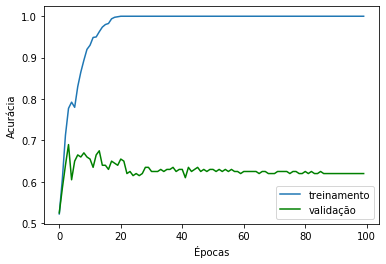

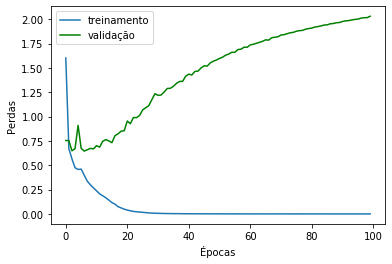

In [91]:
#Acurácia

plt.plot(historico.history['acc'])
plt.plot(historico.history['val_acc'], color='green')
plt.legend(['treinamento','validação'])
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.show()
# perdas

plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'], color='green')
plt.legend(['treinamento','validação'])
plt.xlabel('Épocas')
plt.ylabel('Perdas')
plt.show()